In [2]:
import caffe
import numpy as np
from PIL import Image
import os

In [3]:
caffe.set_device(0)
caffe.set_mode_cpu()

In [4]:
imgs = os.listdir('/home/ankdesh/ssd/datasets/tini-imagenet/tiny-imagenet-200/test/images/')

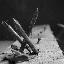

(64, 64)


ValueError: axes don't match array

In [18]:
readImage = Image.open(open('/home/ankdesh/ssd/datasets/tini-imagenet/tiny-imagenet-200/test/images/' + imgs[9]))
display (readImage)
print (np.array(readImage).shape)
npimg = np.array(readImage)
npimg = np.transpose(npimg,(2,0,1))
print (npimg.shape)

readImage = readImage.resize((395,395))
display (readImage)
print (np.array(readImage).shape)


In [21]:
imgs = os.listdir('/home/ankdesh/ssd/datasets/tini-imagenet/tiny-imagenet-200/test/images/')
np100imgs = np.empty(shape=(100,3,395,395))

readImage = Image.open(open('/home/ankdesh/ssd/datasets/tini-imagenet/tiny-imagenet-200/test/images/' + imgs[0]))
readImage = readImage.resize((395,395))
npimg = np.array(readImage)


for i in range(100):
    readImage = Image.open(open('/home/ankdesh/ssd/datasets/tini-imagenet/tiny-imagenet-200/test/images/' + imgs[i]))
    readImage = readImage.resize((395,395))
    npimg = np.array(readImage)
    if (len(npimg.shape) != 3):
        print ('Skipping B/W image:' + str(imgs[i]))
        continue
    #HWC to CHW
    npimg = np.transpose(npimg,(2,0,1))
    np100imgs[i,:,:,:] = npimg

Skipping B/W image:test_7495.JPEG


In [22]:
net = caffe.Net('/home/ankdesh/ssd/models/caffe/inceptionv3/deploy_inception-v3.prototxt', \
                '/home/ankdesh/ssd/models/caffe/inceptionv3/inception-v3.caffemodel', caffe.TEST)

In [24]:
net.blobs['data'].data[...] = npimg
_ = net.forward()

In [37]:
print("Blobs:")
for name, blob in net.blobs.iteritems():
    print("{:<5}:  {}".format(name, blob.data.shape))

Blobs:
data :  (1, 3, 395, 395)
conv1_3x3_s2:  (1, 32, 197, 197)
conv2_3x3_s1:  (1, 32, 195, 195)
conv3_3x3_s1:  (1, 64, 195, 195)
pool1_3x3_s2:  (1, 64, 97, 97)
conv4_3x3_reduce:  (1, 80, 97, 97)
conv4_3x3:  (1, 192, 95, 95)
pool2_3x3_s2:  (1, 192, 47, 47)
pool2_3x3_s2_pool2_3x3_s2_0_split_0:  (1, 192, 47, 47)
pool2_3x3_s2_pool2_3x3_s2_0_split_1:  (1, 192, 47, 47)
pool2_3x3_s2_pool2_3x3_s2_0_split_2:  (1, 192, 47, 47)
pool2_3x3_s2_pool2_3x3_s2_0_split_3:  (1, 192, 47, 47)
inception_a1_1x1:  (1, 64, 47, 47)
inception_a1_5x5_reduce:  (1, 48, 47, 47)
inception_a1_5x5:  (1, 64, 47, 47)
inception_a1_3x3_reduce:  (1, 64, 47, 47)
inception_a1_3x3_1:  (1, 96, 47, 47)
inception_a1_3x3_2:  (1, 96, 47, 47)
inception_a1_pool:  (1, 192, 47, 47)
inception_a1_pool_proj:  (1, 32, 47, 47)
inception_a1_output:  (1, 256, 47, 47)
inception_a1_output_inception_a1_output_0_split_0:  (1, 256, 47, 47)
inception_a1_output_inception_a1_output_0_split_1:  (1, 256, 47, 47)
inception_a1_output_inception_a1_output

In [49]:
def getCellsFromModel(net, widthCell, heightCell):
    for name, blob in net.blobs.iteritems(): # iterate through all the fm blobs
        if name in net.layer_dict.keys(): # Some blobs like 'data' do not have layers with same name
            if net.layer_dict[name].type == 'Convolution': # Looking for convolution blocks only
                #print ([x for x in net._layer_dict[name].blobs[0].shape])
                filters4d = net.layer_dict[name].blobs[0]
                filterNpData = filters4d.data
                print ("Processing {:<7}: FilterSize = {:<2} x {:<2} x {:<2} x {:<2} ".format (name, *[x for x in filters4d.shape]))
                print ("                       IFMSize = {:<3} x {:<3} x {:<3} x {:<3}".format(*[x for x in blob.shape]))
                stride = 1 # *** ASSUMPTION ***
                padEachSideX = filters4d.width / 2 
                padEachSideY = filters4d.height / 2

                paddedData = np.pad(blob.data,((0,0),(0,0), (padEachSideY,padEachSideY), (padEachSideX,padEachSideX)),'constant')
                print ("                Padded IFMSize = {:<3} x {:<3} x {:<3} x {:<3}".format(*paddedData.shape))
                # Iterate all Data
                for n in range(paddedData.shape[0]):
                    listAllChZeros = []
                    for c in range(paddedData.shape[1]):
                        #yield (paddedData[n,c,:,:])
                        countCh = 0
                        for h in range(0, paddedData.shape[2] - widthCell + 1):
                            for w in range(0, paddedData.shape[3]- widthCell + 1):
                                cell = paddedData[n, c, h:h+heightCell, w:w+widthCell]
                                if np.count_nonzero(cell) == 0:
                                    countCh += 1
                        listAllChZeros.append(countCh)
                print (str(n) +)
                        #        yield (n,c,h,w)

In [51]:
asd = getCellsFromModel(net, 4, 4)
for i in range (100000):
    cell = asd.next()
    #print(cell)
    print (np.count_nonzero(cell))

Processing conv1_3x3_s2: FilterSize = 32 x 3  x 3  x 3  
                       IFMSize = 1   x 32  x 197 x 197
                Padded IFMSize = 1   x 32  x 199 x 199
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
3
2
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
3
2
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2
2
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2
3
4
4
4
4
4
3
2
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2
3
4
4
4
4
4
4
4
4
5
4
3
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2
2
2
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2
3
4
4
4
4
4
4
4
4
5
4
3
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2
2
2
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2
2
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2
2
2
1
0
0
0
0
0
0
0
0
0
0
3
6
10
10
7
4
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2
2
2
1
0
0
0
0
0
0
0
0
0
0
3
6
10
10
7
4
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2
2
2
1
0
1
2
2
2
1
0
0
0
0
2
4
8
8
6
4
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2
3
3
2
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2
3
4
4
3
2
1
0
1
2
2
3
3
5
6
6
6
3
2
1
0
0
0
1
2
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
6
7
8
8
8
8
8
7
6
5
4
4
4
4
3
2
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2
3
5
6
6
5
3
1
1
2
2
4
5
8
9
8
7
3
2
1
0
0
0
1
2
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
6
7
7
6
5
4
4
5
4
3
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
3
5
5
4
2
0
2
4
4
4
2
0
1
2
2
4
5
7
9
9
8
7
7
7
8
8
8
6
4
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
6
6
6
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
4
7
7
6
3
0
1
2
2
2
1
0
1
2
2
5
7
8
11
11
10
9
7
5
4
4
4
3
2
1
0
0
0
0
0
0
0
0
0
0
0
0
0
3
4
4
4
4
4
4
3
2
1
0
0
0
0
0
0
0
2
4
4
5
4
2
2
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2
3
4
4
4
3
2
1
1
4
7
8
8
6
4
3
2
2
1
1
1
1
2
2
5
7
7
10
10
9
8
5
2
0
0
1
2
3
4
4
4
4
4
4
4
4
4
4
4
4
4
3
3
4
4
4
4
4
4
3
2
1
0
0
0
0
0
0
0
2
4
4
5
4
2
2
1
0
0
0
0
0

16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
12
9
6
3
3
2
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
12
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
12
10
8
6
6
4
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
12
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16

16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
13
10
7
3
2
1
0
0
0
0
0
0
0
1
2
3
4
4
4
7
10
13
15
12
9
6
4
4
6
8
10
12
12
12
12
10
8
6
6
8
10
10
8
6
7
10
13
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
15
14
14
14
15
15
15
15
15
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
12
6
8
8
8
8
8
8
10
12
14
16
16
16
15
15
15
15
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
14
12
10
6
4
2
0
0
0
0
0
0
0
2
4
6
8
8
8
10
12
14
16
14
12
10
8
8
10
12
14
16
16
16
16
14
12
10
10
12
14
14
12
10
10
12
14
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
12
9
12
12
12
12
12
12
13
14
15
16
16
16
14
14
14
14
1

16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
12
0
0
0
0
2
4
6
10
12
14
16
16
16
12
8
4
0
0
0
0
0
0
3
6
9
12
13
14
15
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
15
14
10
6
3
0
0
0
0
0
0
0
0
0
0
4
6
8
12
12
14
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
12
0
0
0
0
1
2
3
7
10
13
16
16
16
12
8
4
0
0
0
0
0
0
2
4
6
8
10
12
14
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
14
12
8
4
2
0
0
0
0
0
0
0
0
0
0
4
7
10
14
14
15
16
16
16
16
16
16
16
16
16


16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
12
0
0
0
0
4
8
12
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
1

14
13
10
9
8
5
4
2
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2
6
10
13
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
12
12
16
16
16
16
16
16
14
12
10
8
9
10
8
6
3
0
0
0
0
0
0
0
0
0
0
0
0
0
2
4
8
12
14
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
1

16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
12
0
0
0
1
1
1
1
2
2
2
6
8
12
14
14
14
13
15
15
15
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
13
10
6
2
1
0
0
0
0
4
8
12
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
12
0
0
0
1
1
1
1
2
3
4
8
10
13
14
14
14
14
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
12
8
4
0
0
0
0
0
0
4
8
12
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
1

16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
15
14
13
12
10
8
8
8
10
11
11
11
11
12
12
12
13
14
15
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
15
14
13
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
9
7
9
9
9
8
8
8
9
10
11
13
14
15
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
15
14
13
11
10
9
8
8
8
10
12
14
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
14
12
10
8
7
6
6
6
7
7
7
7
7
8
8
8
10
12
14
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
14
12
10
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
6
10
13
13
13
12
12
12
13
14
15
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
15
14
13
12
12
12
13
14
15
16
16
1

16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
15
14
13
9
12
16
16
16
16
16
16
16
16
16
13
10
7
3
2
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
4
8
12
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
12
12
16
16
16
16
16
16
16
16
16
14
12
10
6
4
2
0
0

2
4
4
6
6
6
8
8
8
10
12
14
12
8
4
2
3
4
5
4
4
3
2
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
4
4
4
7
10
13
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
15
14
13
9
6
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
4
7
8
8
6
4
4
4
4
4
4
4
3
2
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
4
4
5
4
3
4
4
4
7
10
13
12
8
4
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
6
8
8
8
10
12
14
16
16
16
16
16
16
15
14
13
13
14
15
16
16
16
15
14
13
12
12
12
12
12
12
12
12
12
9
6
3
0
0
0
0
0
0
0
0
0
0
1
2
3
3
2
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
4
4
4
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2
3
4
4
4
4
4
4
3
2
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2
2
2
1
0
1
1
1
5
8
12
13
10
7
4
4
4
4
4
4
3
2
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2
3
3
2
1
0
9
12
12
12
13
14
15
16
16
16
16
16
16
14
12
10


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
6
10
14
16
16
16
16
16
14
10
6
2
2
4
4
4
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
4
8
12
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
12
12
16
16
16
16
16
16
16
16
16
16
16
16
12
8
4
0
4
8
8
8
4
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
5
9
13
16
16
16
16
16
15
11
7
3
2
4
4
4
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
4
8
12
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
12
12
16
16
16
16
16
16
16
16
16
16
16
16
12
8
4
0
4
8
8
8
4
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

7
8
4
3
3
1
1
2
1
1
3
3
4
5
4
4
7
7
7
7
4
4
7
7
7
7
4
4
5
5
5
5
7
7
7
7
4
4
6
6
6
7
5
5
7
6
6
9
7
7
7
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
3
3
4
4
6
6
6
6
5
5
5
4
2
1
0
0
0
3
3
3
4
1
1
1
0
0
3
3
3
3
0
0
3
3
3
3
0
0
0
0
0
2
2
2
2
0
0
0
3
4
5
9
7
7
7
4
4
3
2
1
4
4
4
5
1
1
1
0
0
0
1
2
3
3
2
5
4
4
4
1
2
3
4
3
2
4
4
5
6
3
2
1
0
0
1
1
1
4
4
5
6
4
4
7
7
7
10
7
7
10
7
7
7
4
4
4
5
5
5
8
7
7
7
3
2
3
2
2
4
2
2
5
4
5
6
4
4
7
7
7
7
4
4
7
7
7
7
4
4
6
6
6
6
7
7
7
7
4
4
5
5
5
7
6
6
7
5
5
8
7
7
7
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
3
3
4
4
6
6
6
6
4
4
4
3
3
3
3
4
4
6
6
6
6
4
4
4
4
4
6
6
6
6
4
4
6
6
6
6
4
4
4
4
4
6
6
6
6
4
4
4
7
8
9
12
10
10
10
8
8
7
6
5
7
7
7
7
4
4
4
4
4
4
5
6
6
6
5
7
7
7
7
5
6
7
7
6
5
7
8
9
9
6
5
4
4
4
4
4
4
7
8
9
10
8
8
10
10
10
12
10
10
12
10
10
10
8
8
8
8
8
8
10
10
10
9
6
5
6
6
6
7
4
3
5
4
5
6
4
4
7
8
9
10
8
8
10
10
10
10
8
8
10
10
10
10
9
8
7
7
6
7
7
6
5
6
6
6
6
5
6
8
8
7
7
5
5
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
6
7
8
8
8
6
0
0
0
3
3
3
3
0
0
0
0
1
2
4
5
5
8
7

5
4
6
4
5
5
4
5
5
6
5
7
7
7
9
6
6
6
3
3
3
6
8
9
12
9
8
6
3
3
3
4
4
4
4
4
6
6
6
8
7
8
8
6
5
6
6
6
9
7
7
7
3
2
1
4
5
6
10
7
7
10
8
9
11
7
5
3
0
0
4
5
6
7
4
4
3
2
1
0
1
2
2
4
5
8
9
8
7
3
3
3
2
2
1
4
4
4
7
3
3
3
1
2
2
2
1
3
4
5
6
3
2
1
0
0
0
0
0
2
2
2
5
3
3
3
0
0
0
0
0
0
0
2
3
3
4
5
5
5
5
5
5
8
7
7
9
5
4
5
3
4
6
4
3
2
0
0
0
0
0
0
0
0
1
1
1
2
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
2
2
2
3
1
1
4
3
3
3
0
0
2
2
2
6
4
4
4
1
2
2
2
1
4
4
4
6
2
2
2
0
0
0
4
5
6
10
6
5
4
0
0
2
3
4
6
5
5
8
7
7
9
6
6
5
3
3
6
7
7
9
5
4
3
0
0
0
4
4
4
8
4
4
8
5
6
8
4
3
2
0
0
4
4
4
4
0
0
0
0
0
0
0
0
1
2
3
7
6
5
4
0
0
0
0
0
0
4
4
4
7
3
3
3
0
0
0
0
0
2
2
2
2
0
0
0
0
0
1
1
1
4
3
3
7
4
4
4
0
0
0
0
0
0
0
2
3
3
5
6
6
6
6
6
6
9
7
7
8
4
3
5
4
5
6
3
2
1
0
0
0
0
0
0
0
0
1
1
1
2
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
3
2
2
5
3
3
3
0
0
1
1
1
5
4
4
4
1
2
2
2
1
4
4
4
5
1
1
1
0
0
0
4
5
6
10
6
5
4
0
0
3
4
5
8
6
6
9
7
7
8
5
5
4
3
3
6
7
7
8
4
3
2
0
0
0
4
4
4
8
4
4
8
5
6
7
3
2
1
0
0
4
4
4
4
0
0
0
0
0
0
0
0
2
3
4
8
6
5
4
0
0
0
0
0
0
4
4
4
7
3
3
3
0
0
0


2
4
4
3
3
1
1
3
2
2
3
2
3
5
4
3
3
2
3
7
6
5
4
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
5
3
4
5
5
5
5
4
3
3
6
6
5
7
3
3
3
0
0
4
5
6
7
3
2
3
3
4
6
4
3
4
2
2
4
3
4
4
2
1
0
3
3
3
3
1
2
6
6
5
4
0
0
2
2
2
5
3
3
7
4
4
4
1
2
2
3
3
4
4
3
2
0
0
2
2
2
2
4
5
6
6
2
1
3
3
3
6
4
5
7
4
3
2
0
0
4
4
4
6
3
4
5
4
4
3
3
3
6
6
5
4
0
0
0
4
4
4
8
4
4
4
1
2
3
3
2
3
2
2
3
1
1
3
3
4
5
3
2
3
3
4
8
6
5
4
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
4
5
8
6
6
6
4
4
4
3
3
3
6
7
7
8
4
3
3
2
3
6
6
6
5
2
1
2
3
4
5
3
2
3
2
2
4
3
4
4
3
3
3
6
6
6
6
5
6
9
9
8
6
2
1
2
2
2
5
3
3
7
4
4
4
1
2
2
4
5
5
5
3
1
1
2
5
6
6
6
7
7
7
6
3
3
5
6
6
9
7
7
8
5
5
4
3
3
6
7
7
9
6
6
6
4
4
3
3
3
6
6
5
4
0
0
0
4
5
6
10
6
5
4
2
4
4
5
4
5
5
4
3
1
2
5
7
8
8
6
5
6
7
8
11
8
6
4
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
4
5
6
10
6
5
4
0
0
0
0
0
0
4
5
6
8
4
3
4
3
4
6
4
3
2
0
0
3
3
3
3
0
0
2
2
2

14
13
12
11
12
12
9
9
9
8
12
13
14
16
16
15
14
13
13
13
13
10
10
11
10
14
14
11
13
13
13
16
16
16
16
16
16
12
11
10
7
11
12
13
16
16
12
12
12
12
16
16
12
12
12
9
13
13
11
14
14
12
14
14
11
13
13
13
14
14
14
14
16
16
12
2
2
2
2
0
0
0
0
0
0
2
2
2
6
4
4
4
0
0
2
2
2
5
3
3
5
3
4
6
4
3
2
0
0
0
0
0
4
4
4
7
3
3
3
2
2
2
5
4
5
9
7
7
8
5
5
6
5
5
8
7
7
8
5
5
4
2
1
0
0
0
0
0
0
3
3
3
3
0
0
0
4
5
6
7
4
4
4
4
4
6
6
6
6
4
4
7
7
7
8
5
5
5
4
4
5
4
3
2
3
6
8
12
13
14
13
13
13
13
16
16
13
12
11
10
12
12
9
9
9
9
13
14
15
16
16
14
13
12
12
13
13
10
10
11
11
15
15
12
13
13
13
16
16
16
16
16
16
12
11
10
8
12
13
14
16
16
12
12
12
12
16
16
12
12
12
9
13
13
12
15
15
14
15
15
12
13
13
13
15
15
15
15
16
16
12
5
5
4
3
1
2
3
3
2
1
2
2
2
5
3
3
3
0
0
3
4
5
8
6
6
8
6
6
6
4
4
3
3
3
3
4
4
7
7
7
9
6
6
6
6
6
6
9
7
7
9
6
6
6
4
4
4
4
4
6
6
6
6
4
4
3
2
1
0
0
0
0
1
2
5
5
4
3
0
0
0
3
4
5
6
4
4
4
5
6
9
9
8
8
6
7
10
10
10
10
8
8
8
8
8
8
7
6
5
6
8
10
13
14
15
13
12
11
11
14
15
13
12
11
10
11
10
7
6
6
8
11
12
13
13
14
12
11
9
9
10
1